In [1]:
using QuantEcon, Optim, CairoMakie, LinearAlgebra, Dierckx

In [7]:
function create_model(;nk = 31)#, nl = 31)

    p = (;α = 0.33, # Capital share
        β = 0.9, # Discount factor
        δ = 0.1, # Dep rate
        A = 1.0, # TFP
        γ = 2.0, # Risk aversion
        θ = 3.0, # Grid expansion parameter
        η = 0.8, # Frisch elasticity
        ι = 2.0, # Labour weight
        kmin = 1.0, # Lower bound of capital
        kmax = 2.0, # Upper bound of capital
        kgrid = zeros(Float64, nk), # Capital grid
        tol = 1e-6, # VFI tolerance
        maxiter = 10_000, # Maximum number of iterations
        print_skip = 100, # Print every print_skip iterations
        nk = nk) # Number of capital grid points

    # Create capital grid
    temp_grid = LinRange(0,1,nk)
    kgrid = p.kmin .+ (p.kmax - p.kmin) * temp_grid.^p.θ

    # Return new NamedTuple
    p = (;p..., kgrid = kgrid)

    return p
end

model = create_model()

(α = 0.33, β = 0.9, δ = 0.1, A = 1.0, γ = 2.0, θ = 3.0, η = 0.8, ι = 2.0, kmin = 1.0, kmax = 2.0, kgrid = [1.0, 1.000037037037037, 1.0002962962962962, 1.001, 1.0023703703703704, 1.0046296296296295, 1.008, 1.0127037037037037, 1.018962962962963, 1.027  …  1.343, 1.3943703703703703, 1.4506296296296297, 1.512, 1.5787037037037037, 1.650962962962963, 1.729, 1.813037037037037, 1.9032962962962963, 2.0], tol = 1.0e-6, maxiter = 10000, print_skip = 100, nk = 31)

In [3]:
function u(c, p)
    (; γ) = p
    if γ == 1.0
        return log(c)
    else
        return (c^(1-γ)-1)/(1-γ)
    end
end

function v(l, p)
    (; η, ι) = p
    return ι*((l)^(1+η))/(1+η)
end

function resources(k, l, p)
    (; A, α, δ) = p
    return A*(k^α)*(l^(1-α))+(1-δ)*k
end

function interpV(grid, v)
    return Spline1D(grid, v, k=3, bc="extrapolate")
end

function prob(kgrid, i, x, interp_v, p)
    (; β) = p
    return -[u(resources(kgrid[i],x[2],p)-x[1], p) - v(x[2], p) + β*interp_v(x[1])][1,1]
    #return -[u(resources(kgrid[i],x[2],p)-x[1], p) + β*interp_v(x[1])][1,1]
end

function B!(Vnew, interp_v, pol_k, pol_l, kgrid, p)
    (; nk, β) = p
    lb = [resources(kgrid[1], 0.0, p), 0.1]
    for i in 1:nk
        ub = [resources(kgrid[i], 1.0, p), 1.0]
        obj(x) = prob(kgrid, i, x, interp_v, p)
        res = optimize(obj, lb, ub, [kgrid[i], 0.5])
        Vnew[i] = -res.minimum
        pol_k[i] = res.minimizer[1]
        pol_l[i] = res.minimizer[2]
    end
    return Vnew, pol_k, pol_l
end

B! (generic function with 1 method)

In [8]:
function solve(p)
    (; tol, maxiter, print_skip, nk, kgrid) = p

    # Print
    println("Iterating...")

    # Initialise arrays
    V = zeros(Float64, nk)
    Vnew = zeros(Float64, nk)
    pol_k = zeros(Float64, nk)
    pol_l = ones(Float64, nk)

    # Pre-allocate interpolation
    interp_v = interpV(kgrid, V)

    # Run VFI
    error = tol + 1.0
    iter = 0
    while ((error > tol) && (iter < maxiter))
        if iter > 0
            interp_v = interpV(kgrid, V)
        end
        B!(Vnew, interp_v, pol_k, pol_l, kgrid, p)
        error = maximum(abs.(Vnew .- V)) 
        V .= Vnew
        if iter % print_skip == 0
            println("--------------------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter +=1
    end
    println("--------------------------------")
    println("Completed in $iter iterations")
    return V, pol_k, pol_l
end

v_out, pol_k_out, pol_l_out = solve(model)

Iterating...
--------------------------------
Iteration: 0, Error: 0.8461137116576046
--------------------------------
Iteration: 100, Error: 2.7463632919833003e-5
--------------------------------
Completed in 133 iterations


([-10.270700087005931, -10.270602712137025, -10.269921172191436, -10.268072019805642, -10.264474145560165, -10.25855145461508, -10.249736561021749, -10.237475422414853, -10.22123279745676, -10.200498357208371  …  -9.475968076663941, -9.371987762972337, -9.26171972650252, -9.145437779481156, -9.023446205820113, -8.896072973257883, -8.763663206385429, -8.626573186886759, -8.485165020251893, -8.339800971927444], [1.0724308178343314, 1.0724609935251865, 1.0726722212351292, 1.073245534767275, 1.0743619095393342, 1.0762022014775185, 1.0789470755306607, 1.0827769191018437, 1.087871367733833, 1.0944096856452967  …  1.3494775167004969, 1.3906698663305967, 1.4357236664119297, 1.48480969357632, 1.5380992741379564, 1.5957647256850196, 1.657980815527826, 1.724922091480978, 1.7967753301641805, 1.873713301051404], [0.7732492473808684, 0.7732415691003091, 0.7731878282891111, 0.7730420236180404, 0.7727583536297605, 0.7722914503964651, 0.7715967119102943, 0.7706307208735715, 0.7693514329517347, 0.767719

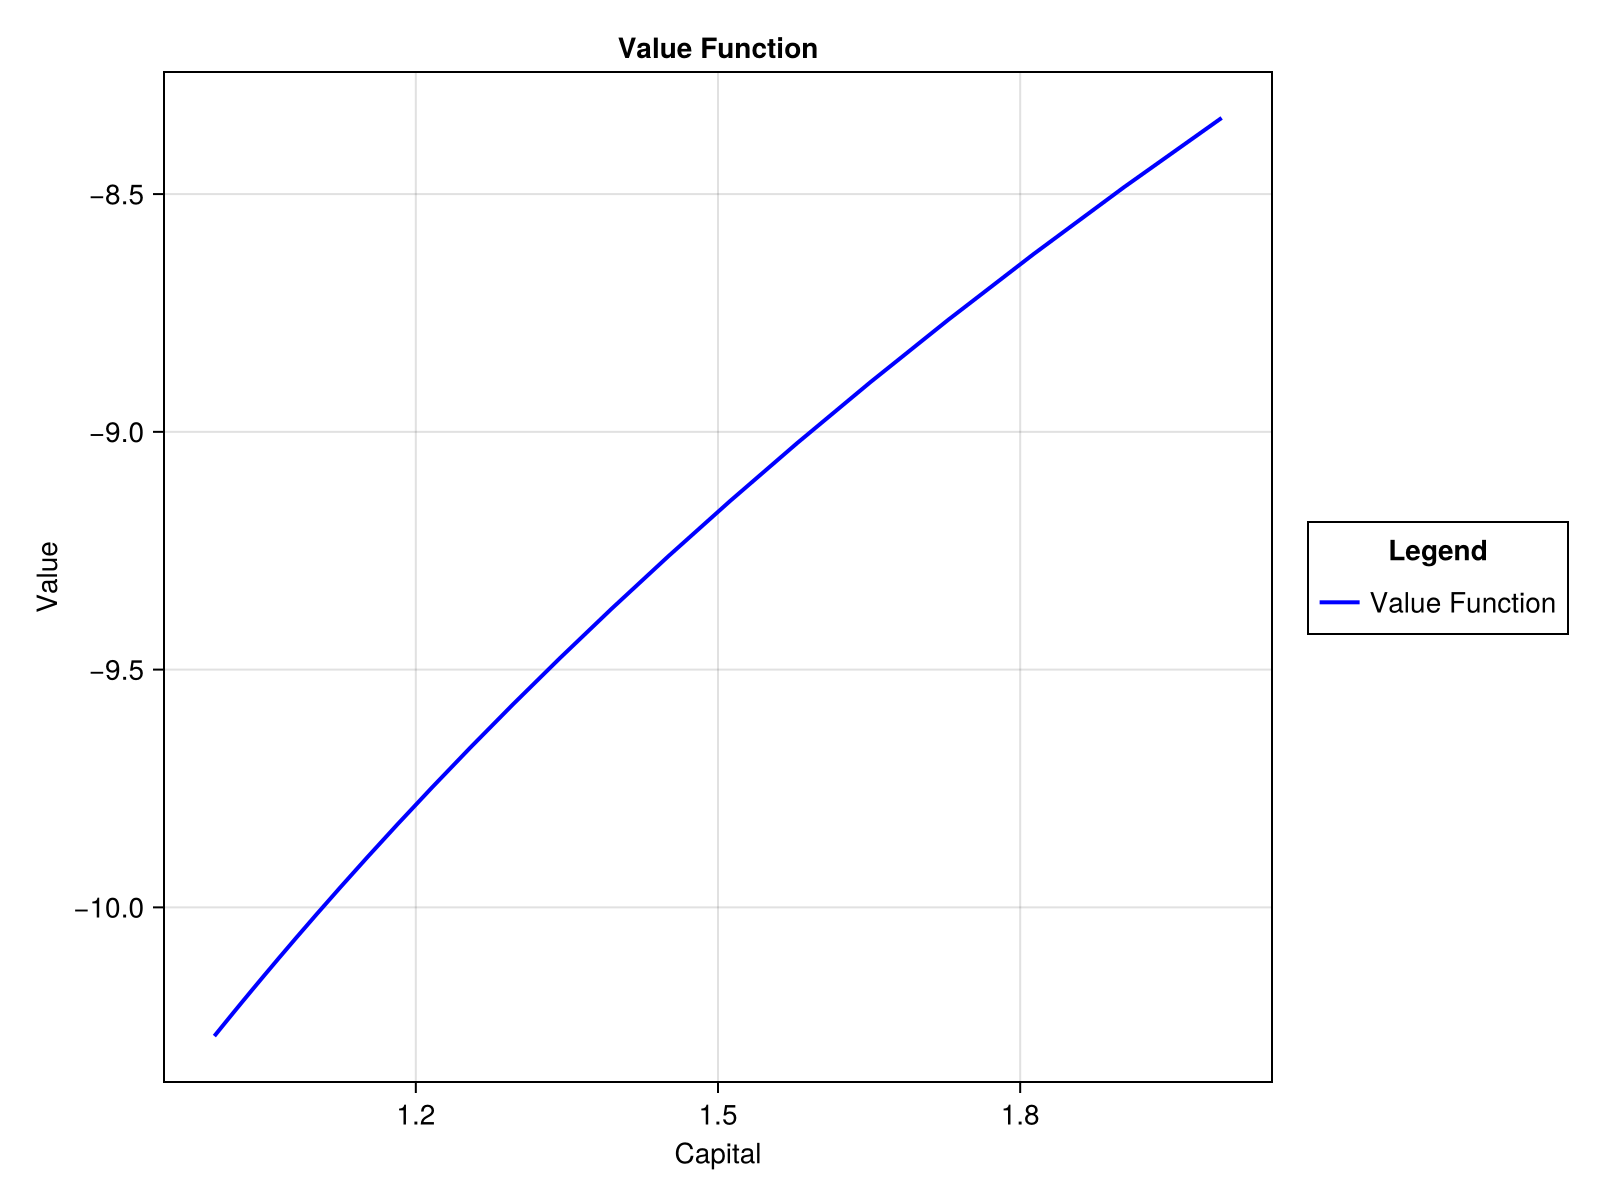

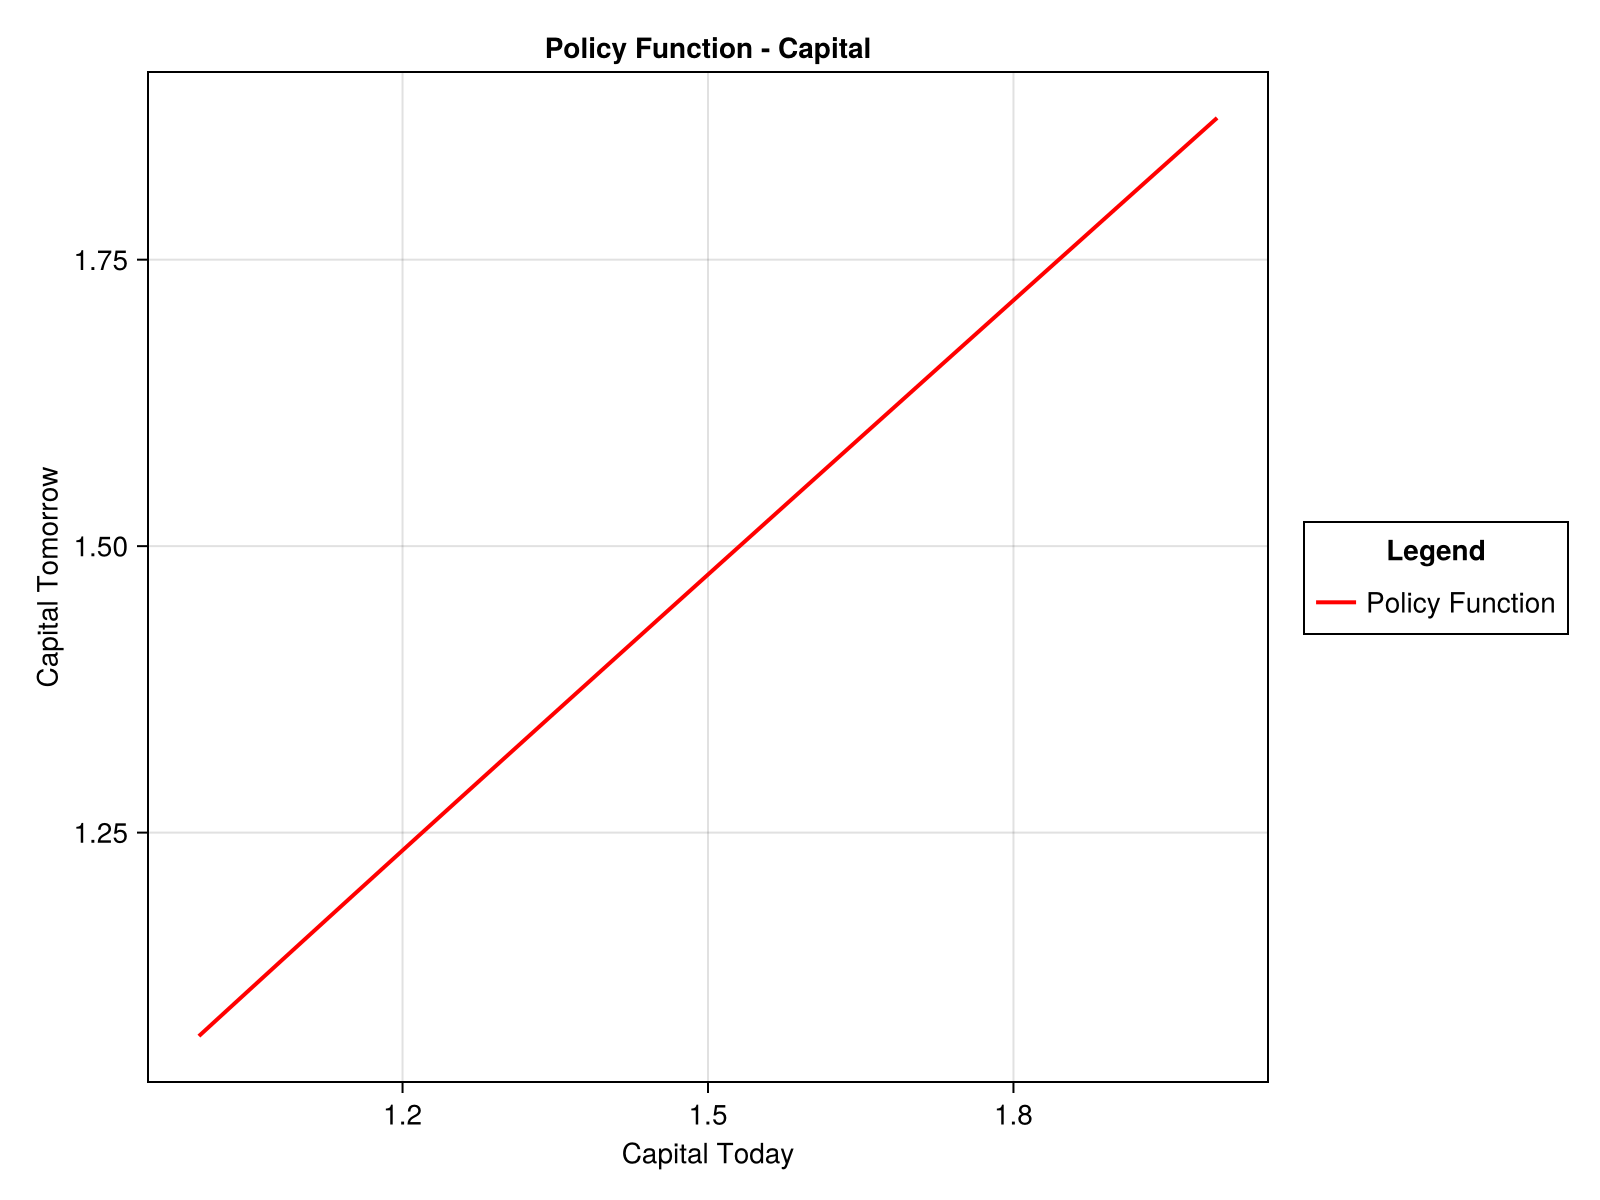

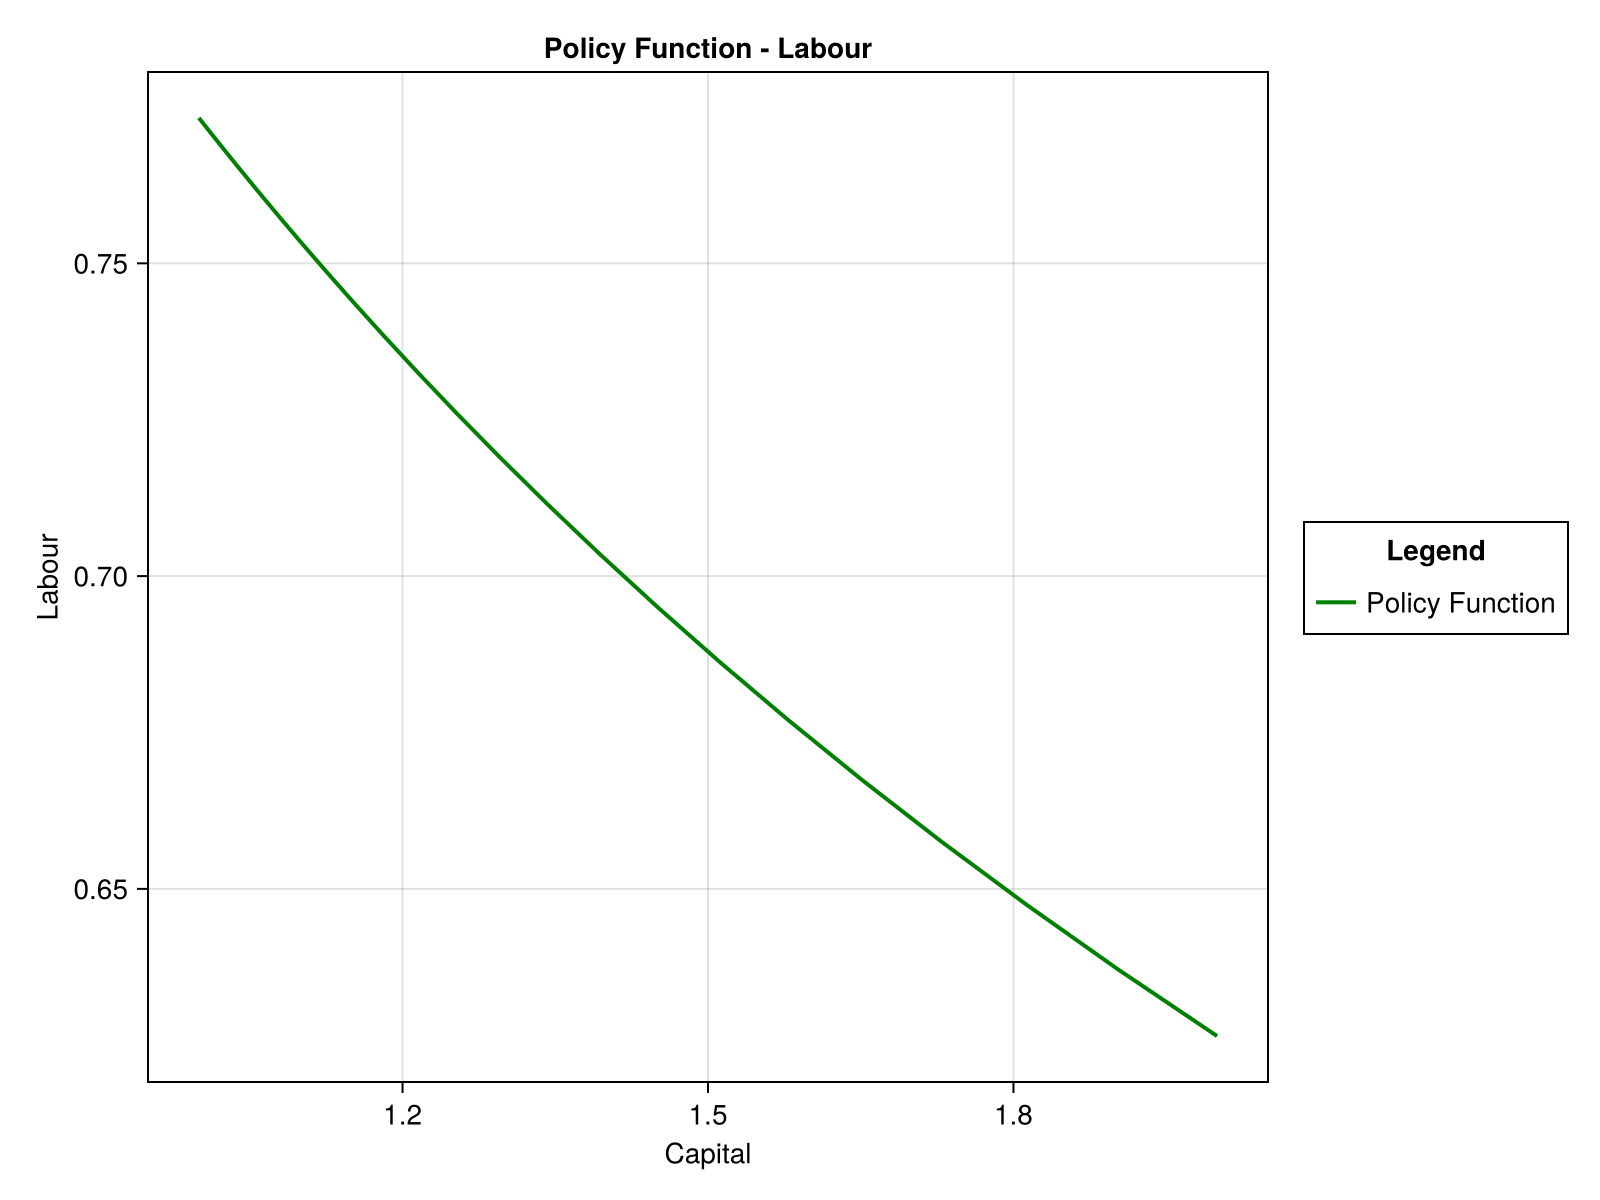

In [14]:
figv = Figure(size = (800, 600))
axv = Axis(figv[1, 1], xlabel = "Capital", ylabel = "Value", title = "Value Function")
lines!(axv, model.kgrid, v_out, color = :blue, linewidth = 2, label = "Value Function")
legend = Legend(figv[1, 2], axv, "Legend", orientation = :vertical)
display(figv)

figk = Figure(size = (800, 600))
axk = Axis(figk[1, 1], xlabel = "Capital Today", ylabel = "Capital Tomorrow", title = "Policy Function - Capital")
lines!(axk, model.kgrid, pol_k_out, color = :red, linewidth = 2, label = "Policy Function")
legend = Legend(figk[1, 2], axk, "Legend", orientation = :vertical)
display(figk)

figl = Figure(size = (800, 600))
axl = Axis(figl[1, 1], xlabel = "Capital", ylabel = "Labour", title = "Policy Function - Labour")
lines!(axl, model.kgrid, pol_l_out, color = :green, linewidth = 2, label = "Policy Function")
legend = Legend(figl[1, 2], axl, "Legend", orientation = :vertical)
figl